In [ ]:
#git clone https://github.com/lucidrains/iTransformer.git

In [1]:
# TODO which one?
#import iTransformer
import sys
sys.path.append('/vol/fob-vol7/nebenf21/reinbene/bene/MA/iTransformer') 
from iTransformer import iTransformer
import torch
from pathlib import Path

import torch
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from utils import data_handling, helpers
import config
print("Import succesfull")


Import succesfull


In [70]:
# load dataset
df = data_handling.load_eu_electricity()
df = df.drop('date', axis=1)

tensor_list = []

# convert each time series to tensor
for column in df.columns:
	tensor = torch.tensor(df[column].values, dtype=torch.float32)
	tensor_list.append(tensor)

result_tensor = torch.stack(tensor_list)
result_tensor = result_tensor.transpose(0,1)

# train/val/test split
train_cutoff = 0.7
validation_cutoff = 0.8

train_cutoff = int(round(train_cutoff * result_tensor.size(0)))
validation_cutoff = int(round(validation_cutoff * result_tensor.size(0)))

data_dict = {}
data_dict["train"] = result_tensor[0:train_cutoff, :]
data_dict["validation"] = result_tensor[train_cutoff : validation_cutoff, :]
data_dict["test"] = result_tensor[validation_cutoff : , :]

# TODO the standardizer inserts nans 
# normalize train and use matrics for val and test
data_dict["train"], train_standardize_dict = helpers.custom_standardizer(data_dict["train"])
#data_dict["validation"], _ = helpers.custom_standardizer(data_dict["train"], train_standardize_dict)
#data_dict["test"], _ = helpers.custom_standardizer(data_dict["train"], train_standardize_dict)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

window_size = 96
pred_length = (96, 192, 336, 720)

# convert to dataloader
dataloader_train, dataloader_validation, dataloader_test = data_handling.convert_data(data_dict, window_size, pred_length)


Using device: cuda
Feature batch shape: torch.Size([32, 96, 208])


In [71]:
for key, value in data_dict.items():
    has_nan = torch.any(torch.isnan(value))
    print(has_nan)


tensor(True)
tensor(False)
tensor(False)


In [64]:
input, target = next(iter(dataloader_train))
input[0,0,:]

tensor([ 0.0277, -0.6912,  2.1231,  0.0060, -0.6348,  1.7862,  1.8146,  1.5403,
         0.5443, -0.6720, -0.4933, -0.0248,  0.9557, -0.5849,  0.9970,  2.9431,
         0.0683, -0.0436, -0.6356,  0.9278, -0.3273,  1.2634, -0.6560, -0.6577,
         1.3269,  2.7944,  2.2047,  1.3051,  2.5366,  1.7405,  1.3187,  2.6811,
         2.1353, -0.5756, -0.6381,  2.7549,  1.9652,  2.7329, -0.1225, -0.6497,
         2.8659, -0.3530, -0.6494,  2.3228,  2.4802,  2.0551, -0.3673, -0.6393,
         2.9927, -0.7491,  0.6695, -0.6098,  1.5024,  2.1215, -0.1354,  1.1400,
         1.5422,  2.4608, -0.6634, -2.0033, -0.6056,  2.4161,  1.4756,  2.6304,
        -0.8418, -1.8923, -0.5976,  0.8135,  0.2318,  1.3020, -0.1544,  0.6991,
         2.9640, -0.1695, -0.8434, -0.4243,  0.6984,  3.2555,  0.4069, -0.7272,
         2.1980, -0.4824, -0.1471,  0.9027, -0.6519, -0.6664,  1.6514,  2.3073,
         1.5747,  1.7343,  2.0375,  1.2226,  1.5127,  2.2246,  1.6293,  0.3780,
         1.2953,  1.2449,  2.7240, -0.45

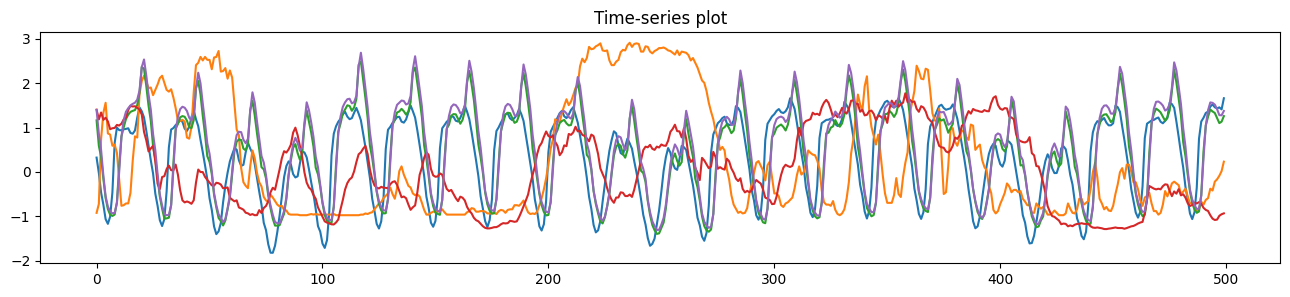

In [56]:
import pandas
from utils import data_handling, helpers
import random
import matplotlib.pyplot as plt

# sanity check if conversion worked correctly
# select 5 random time-series and 500 datapoints each
train_tensor = data_dict["train"]

time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)

numpy_array = train_tensor[time_id : time_id+500 , ids : ids+5].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

In [24]:
window_size = 96
pred_length = (96, 192, 336, 720)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_dict = data_handling.load_electricity()
dataloader_train, dataloader_validation, dataloader_test = data_handling.convert_data(data_dict, window_size, pred_length)

Using device: cuda
Feature batch shape: torch.Size([32, 96, 348])


In [37]:
model_config = {
    'num_variates': data_dict["train"].size(1),
    'lookback_len': window_size,
    'depth': 6,
    'dim': 512,
    'num_tokens_per_variate': 1,
    'pred_length': pred_length,
    'dim_head': 32,
    'heads': 4,
    'attn_dropout': 0.1,
    'ff_mult': 4,
    'ff_dropout': 0.1,
    'num_mem_tokens': 4,
    'use_reversible_instance_norm': True,
    'reversible_instance_norm_affine': False,
    'flash_attn': True
}

# defining all needed instances
model = iTransformer(**model_config).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
writer = SummaryWriter(log_dir=config.CONFIG_LOGS_PATH["revin"])


In [38]:
def fast_eval(dataloader):
	model.eval()
	preds_dict = {
		96 : {
				"mse" : 0, "mae" : 0, "smape":0, "p10" : 0, "p50" : 0, "p90" : 0
		},
		192 : {
				"mse" : 0, "mae" : 0, "smape":0, "p10" : 0, "p50" : 0, "p90" : 0
		},
		336 : {
				"mse" : 0, "mae" : 0, "smape":0, "p10" : 0, "p50" : 0, "p90" : 0
		},
		720: {
				"mse" : 0, "mae" : 0, "smape":0, "p10" : 0, "p50" : 0, "p90" : 0
		}}

	with torch.no_grad():
		for input, target in tqdm(dataloader, desc=f"Epoch: Validating"):
			input = input.to(device)
		
			# targets are saved as dict, send each to device
			targets = (target[0].to(device), target[1].to(device), target[2].to(device), target[3].to(device))
			outputs = model(input)
		
		# for each prediciton length we calculate the metrics
		for target, output in zip(targets, outputs.values()):
			preds_dict[output.size(1)]["mse"] = preds_dict[output.size(1)]["mse"] + helpers.mean_squared_error(output, target)
			preds_dict[output.size(1)]["mae"] = preds_dict[output.size(1)]["mae"] + helpers.mean_absolute_error(output, target)
			preds_dict[output.size(1)]["smape"] = preds_dict[output.size(1)]["smape"] + helpers.symmetric_mean_absolute_percentage_error(output, target)
			preds_dict[output.size(1)]["p10"] = preds_dict[output.size(1)]["p10"] + helpers.percentile(output, target, 0.1)
			preds_dict[output.size(1)]["p50"] = preds_dict[output.size(1)]["p50"] + helpers.percentile(output, target, 0.5)
			preds_dict[output.size(1)]["p90"] = preds_dict[output.size(1)]["p90"] + helpers.percentile(output, target, 0.9)

	print(preds_dict[192].items())

	
	return preds_dict

In [41]:
def train_one_epoch(epoch, model, device, dataloader_train, dataloader_validation, optimizer, scheduler, writer):
	global_step = 0
	model.train()
	total_loss = 0
	
	for input, target in tqdm(dataloader_train, desc=f"Epoch: {epoch}"):
		optimizer.zero_grad()
		if len(target) == 4:
			loss = model(input.to(device), (target[0].to(device), target[1].to(device), target[2].to(device), target[3].to(device)))
		else:
			loss = model(input.to(device), target.to(device))
		print(loss)
		
		loss.backward()
		optimizer.step()
		total_loss += loss.item()

		writer.add_scalar('train_loss', loss, global_step)
		writer.add_scalar('train_lr', optimizer.param_groups[0]['lr'], global_step)
		lr =  optimizer.param_groups[0]['lr']
		global_step+=1

	print(f'Epoch {epoch}, MSE-Loss: {total_loss / (len(dataloader_train) * 4)}, LR: {lr}')

	scheduler.step()
	writer.close()
	if epoch % 5 == 0:
		helpers.create_checkpoint(model, optimizer, scheduler, epoch, loss, global_step, "iTransfomrer_electricity")
	eval_metrics_dict = fast_eval(dataloader_validation)

epoch = 1

for epoch in range(1, epoch + 1):
	train_one_epoch(epoch, model, device, dataloader_train, dataloader_validation, optimizer, scheduler, writer)


Epoch: 1:   0%|          | 2/929 [00:00<01:54,  8.08it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   0%|          | 4/929 [00:00<01:44,  8.85it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   1%|          | 6/929 [00:00<01:45,  8.72it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   1%|          | 8/929 [00:00<01:41,  9.04it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   1%|          | 10/929 [00:01<01:42,  8.99it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   1%|▏         | 12/929 [00:01<01:38,  9.27it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   2%|▏         | 14/929 [00:01<01:38,  9.31it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   2%|▏         | 16/929 [00:01<01:39,  9.20it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   2%|▏         | 18/929 [00:01<01:38,  9.27it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   2%|▏         | 20/929 [00:02<01:39,  9.12it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   2%|▏         | 22/929 [00:02<01:38,  9.22it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   3%|▎         | 24/929 [00:02<01:38,  9.16it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   3%|▎         | 26/929 [00:02<01:37,  9.29it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   3%|▎         | 28/929 [00:03<01:35,  9.43it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   3%|▎         | 30/929 [00:03<01:35,  9.42it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   3%|▎         | 32/929 [00:03<01:35,  9.41it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   4%|▎         | 34/929 [00:03<01:34,  9.51it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   4%|▍         | 36/929 [00:03<01:35,  9.38it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   4%|▍         | 38/929 [00:04<01:32,  9.58it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   4%|▍         | 40/929 [00:04<01:34,  9.42it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   5%|▍         | 42/929 [00:04<01:33,  9.46it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   5%|▍         | 44/929 [00:04<01:33,  9.43it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   5%|▍         | 46/929 [00:04<01:34,  9.37it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   5%|▌         | 48/929 [00:05<01:33,  9.40it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


Epoch: 1:   5%|▌         | 50/929 [00:05<01:35,  9.25it/s]

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)
tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [33]:
def eval_function(valid_dataloader):
	try:
		model = iTransformer(**model_config)

	except UnboundLocalError:
		checkpoint = torch.load("/vol/fob-vol7/nebenf21/reinbene/bene/MA/outputs/series_standardized/model_first_20_ids_full_epoch_10.pt")
		model.load_state_dict(checkpoint['model_state_dict'])
		optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
		scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
		scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
		writer = SummaryWriter(log_dir='logs')
		device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		model.to(device)

	model.eval()
	global_loss_dict = {
					"mse" : 0,
					"mae" : 0,
					"p10" : 0,
					"p50" : 0,
					"p90" : 0
				}
	
	with torch.no_grad():
		for input, target in tqdm(valid_dataloader, desc=f"Epoch: Validating"):
			input = input.to(device)
			target = target.to(device)
			
			output = model(input)

			global_loss_dict = helpers.evaluate(global_loss_dict, output, target.to(device))

	for key, values in global_loss_dict.items():
		print(f"{key} loss: {values}")
		writer.add_scalar(key, value/len(valid_dataloader))
	writer.close()

In [34]:
eval_function(dataloader_validation)

ValueError: __len__() should return >= 0

In [35]:
eval_function(dataloader_test)

Epoch: Validating:   0%|          | 0/67 [00:00<?, ?it/s]


UnboundLocalError: local variable 'device' referenced before assignment